In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from google.colab import drive
from tqdm import tqdm
from tabulate import tabulate
import statsmodels.formula.api as smf
from typing import List, Tuple, Dict
import os
import glob
import gc
import subprocess
import sys
from scipy.optimize import minimize
try:
    from linearmodels.panel import PanelOLS
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "linearmodels"])
    import linearmodels
    from linearmodels.panel import PanelOLS
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Quantitative Investment Portfolio/Data/'

Mounted at /content/drive


In [55]:
ff = pd.read_csv(data_dir + 'Fama_french.csv')
ff.dropna(inplace=True)
ff.yyyymm = ff.yyyymm.astype(int)
ff.rename(columns={'Mkt-RF':'mkt_rf'},inplace=True)
ff['date'] = pd.to_datetime(ff['yyyymm'],format='%Y%m')+pd.DateOffset(months=-1)
returns = pd.read_parquet(data_dir + 'processed_returns.parquet')

In [78]:
returns.drop(columns=['ret','lnP','ret','lnsize','hsiccd','RF'],inplace=True)

In [79]:
imputed = os.path.join(data_dir, "imputed/industry_mean.parquet")
df = pd.read_parquet(imputed)

In [80]:
df = pd.merge(df,returns,on=['yyyymm','permno'],how='left')
df['date'] = pd.to_datetime(df.yyyymm,format='%Y%m')

In [81]:
rets = '12m.lret'
model = {'model':'Industry_mean_12_months','data':df,'vars': df.columns[df.columns.str.contains('z')],'yvar':rets,'train_freq':'12m','turnover':'year'}

In [82]:
var = df.columns[df.columns.str.contains('z')]
yvar = '12m.lret'
data = df.drop_duplicates(subset=['yyyymm','permno']).dropna(subset=yvar)
train_freq = '12m'
turnover  = 'year'
coeffs = pd.DataFrame()
coefs = pd.DataFrame()
sig_vars = None
ports = {}
performance = {}
carhart = {}

In [157]:
def eqw_mean( x: pd.Series) -> float:
    """
    Calculate equal-weighted returns mean with exp transformation.
    """
    if len(x) == 0 or x.isna().all():return np.nan  # Added check for empty/all-NA series
    return np.nanmean(np.exp(x/100) - 1)*100

In [61]:
def crossreg(df: pd.DataFrame,yvar,var):
    """
    Perform Fama-MacBeth cross-sectional regression analysis.
    """
    if len(df) == 0:return  # Added check for empty DataFrame
    df = df.dropna(subset=[yvar] + list(var))
    coefs = {}
    for i in sorted(df.yyyymm.unique()):
        X = df[df.yyyymm == i]
        try:
            model = PanelOLS(X[yvar], sm.add_constant(X[var]), entity_effects=False,time_effects=False,other_effects=X['ind'],drop_absorbed=True).fit()
            #model = sm.OLS(X[self.yvar], sm.add_constant(X[self.var])).fit()
            p = model.params
            p.loc['Rsq'] = model.rsquared
            coefs[i] = p
        except Exception as e:
          #print(f'Regression failed for',e)
          continue
    #self.coeffs = pd.DataFrame(coefs)
    coeffs = pd.concat(coefs, axis=1)
    #print(self.coeffs)
    return coeffs

def coefsm(coeffs):
    """
    Calculate coefficient statistics including factor premia and t-statistics.
    """
    coefs = pd.DataFrame()
    if coeffs.empty:return  # Added check for empty coeffs
    n = coeffs.shape[1]
    coefs['f_premia'] = coeffs.mean(axis=1)
    coefs['f_std'] = coeffs.std(axis=1)
    coefs['tstat'] = np.sqrt(n) * coefs['f_premia'] / coefs['f_std']
    return coefs

In [62]:
def scor_rank(df: pd.DataFrame,coefs,sig_vars,turnover):
    """
    Calculate composite scores and decile rankings for portfolio formation.
    """
    df['score'] = sum(df[i] * coefs.loc[i, 'tstat'] for i in sig_vars)
    if(turnover == 'year'):
        jan_mask = df.month == 1
        jan_rankings = df.loc[jan_mask,['year','permno','score']].copy()
        jan_rankings['rank'] = jan_rankings.groupby('year')['score'].transform(
            lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))
        jan_rankings.drop('score',axis=1,inplace=True)
        df = pd.merge(df,jan_rankings,on=['year','permno'],how='left',validate='many_to_one')
    else:
        df['rank'] = df.groupby('yyyymm')['score'].transform(
        lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))
    return df

In [158]:
def portfolio(df: pd.DataFrame):
    """
    Construct long-short portfolio returns from decile rankings.
    """
    df = df.loc[df['rank'].isin([0, 9])].copy()
    df.loc[df['rank'] == 9, 'longRet']  = df.loc[df['rank'] == 9, '1m.lret']
    df.loc[df['rank'] == 0, 'shortRet'] = df.loc[df['rank'] == 0, '1m.lret']
    portfolio = df.groupby('yyyymm')[['longRet', 'shortRet']].agg(eqw_mean)
    portfolio['LongShort'] = portfolio['longRet'] - portfolio['shortRet']
    return portfolio

In [163]:
def performance_metrics(ports):
    """
    Calculate portfolio performance metrics including returns and Sharpe ratios.
    """
    performance = {}
    for t,port in ports.items():
        #ports_e = 100 * (np.exp(port / 100) - 1)
        perf = pd.DataFrame()
        perf['mean_returns'] = port.mean()
        perf['std_dev'] = port.std()
        perf['sharpe_ratio'] = perf['mean_returns'] / perf['std_dev']
        perf['Cumulative Return'] = ((port/100 + 1).prod()-1)*100
        performance[t] = perf.T
    return performance

In [137]:
def Alpha(ports,ff,strat,factors):
    """
    Calculate factor model metrics for portfolio returns.
    """
    models = {}
    for t,port in ports.items():
        model = sm.OLS(port[strat], sm.add_constant(port[factors])).fit()
        models[t] = model
    return models

In [237]:
df['date'] = pd.to_datetime(df['yyyymm'],format='%Y%m')
train = df.loc[df.s == 0].copy()
train = train.set_index(['date','permno'])
test  = df.loc[df.s == 1].copy()
train_a = train
if train_freq == '6m':
    train_a = train.loc[train['month'].isin([1, 7])]
elif train_freq == '12m':
    train_a = train.loc[train['month'] == 1]

In [238]:
coeffs = crossreg(train_a,yvar,var)
train = train.reset_index()
coefs = coefsm(coeffs)

In [85]:
'''
zlnP is quite significant and negative which means lower priced stocks perform better. Reasonable
zlnsize is a litle significant showing positive effect, implying bigger firms perform better.
zAbnormal Accurals imply ?
zAssetGrowwth is positive, firms which are actively expanding provide better results.
zCPVolSpread shows that when there is more uncertainity about stock there is a +ve effect on returns.
zEarningsStreak is not entirely significant but it has a +ve sign
zFEPS is quite significant and positive emplying forecasted EPS being high has a +ve effect on returns
zfgr5yrLag is pretty interesting as it is negative - A probable reason is that high 5yr growth imply higher forward beta.
zGP is positive and significant

'''

'\nzlnP is quite significant and negative which means lower priced stocks perform better. Reasonable\nzlnsize is a litle significant showing positive effect, implying bigger firms perform better.\nzAbnormal Accurals imply ?\nzAssetGrowwth is positive, firms which are actively expanding provide better results.\nzCPVolSpread shows that when there is more uncertainity about stock there is a +ve effect on returns.\nzEarningsStreak is not entirely significant but it has a +ve sign\nzFEPS is quite significant and positive emplying forecasted EPS being high has a +ve effect on returns\nzfgr5yrLag is pretty interesting as it is negative - A probable reason is that high 5yr growth imply higher forward beta.\nzGP is positive and significant\n\n'

In [86]:
coefs[abs(coefs['tstat'])>2]

,f_premia,f_std,tstat
zlnP,-4.212780,4.030068,-4.434991
zAssetGrowth,0.591356,1.089236,2.303369
zCPVolSpread,0.457774,0.956227,2.031078
zFEPS,2.751237,3.304151,3.532680
zGP,1.281397,1.580571,3.439585
zGrLTNOA,0.398273,0.830595,2.034363
zIdioVol3F,2.372281,2.272717,4.428504
zIntMom,-0.812798,1.467009,-2.350639
zMomOffSeason,1.330088,1.454004,3.881067
zMomSeason,-0.888899,1.163774,-3.240560


In [87]:
coefs[(abs(coefs['tstat'])<2) & (abs(coefs['tstat'])>1)]

,f_premia,f_std,tstat
zAbnormalAccruals,0.370050,0.850882,1.845131
zbetaVIX,-0.486106,1.663574,-1.239725
zEarningsStreak,0.422977,1.435844,1.249815
zfgr5yrLag,-0.575246,1.841637,-1.325212
zHigh52,1.856182,4.723196,1.667327
zInvestment,0.304228,1.027444,1.256252
zMom6m,-0.352686,1.466222,-1.020529
zOperProfRD,0.729029,1.623056,1.905670
zOScore,0.374096,1.298824,1.221994
zSurpriseRD,0.236867,0.854143,1.176549


In [239]:
sig_vars = [v for v in coefs[abs(coefs.tstat) > 2].index
              if v not in ['const', 'Rsq']]

In [240]:
sig_vars = sig_vars + ['zAbnormalAccruals','zTK','zDebtIssuance','zHigh52','zInvestment','zfgr5yrLag','zEarningsStreak','zCPVolSpread']

In [241]:
sig_vars

['zlnP',
 'zAssetGrowth',
 'zCPVolSpread',
 'zFEPS',
 'zGP',
 'zGrLTNOA',
 'zIdioVol3F',
 'zIntMom',
 'zMomOffSeason',
 'zMomSeason',
 'zRD',
 'zShareIss1Y',
 'zSmileSlope',
 'zmarket_age',
 'zAbnormalAccruals',
 'zTK',
 'zDebtIssuance',
 'zHigh52',
 'zInvestment',
 'zfgr5yrLag',
 'zEarningsStreak',
 'zCPVolSpread']

In [242]:
train = scor_rank(train,coefs,sig_vars,turnover)
test  = scor_rank(test,coefs,sig_vars,turnover)

In [243]:
ports['train'] = portfolio(train)
ports['test']  = portfolio(test)

In [244]:
ports['test'].head(3)

,longRet,shortRet,LongShort
yyyymm,,,
201401,4.545502,6.278218,-1.732716
201402,1.373050,-3.078935,4.451985
201403,-1.763736,-5.083476,3.319740


In [245]:
performance = performance_metrics(ports)

In [246]:
print('Train:')
print(performance['train'])
print('Test:')
print(performance['test'])

Train:
                       longRet   shortRet    LongShort
mean_returns          1.518104   0.309885     1.208220
std_dev               4.347233   6.905156     3.973661
sharpe_ratio          0.349212   0.044877     0.304057
Cumulative Return  3422.809849  18.050443  1602.985786
Test:
                      longRet   shortRet   LongShort
mean_returns         1.270537   0.547781    0.722756
std_dev              4.955647   6.424669    3.310724
sharpe_ratio         0.256382   0.085262    0.218308
Cumulative Return  289.095197  50.214472  121.096871


In [247]:
for t,port in ports.items():
    port['date'] =  pd.to_datetime(port.index,format='%Y%m')
    ports[t] = port.merge(ff, on='date', how='left')
    if(ports[t].isna().sum().sum()>0):
        print(ports[t].isna().sum())
        ports[t].dropna(inplace=True)
    if(np.isinf(ports[t]).sum().sum()>0):
        print(ports[t].isna().sum())
        ports[t][np.isinf(ports[t])] = np.nan
        ports[t].dropna(inplace=True)

longRet      1
shortRet     1
LongShort    1
date         0
yyyymm       1
mkt_rf       1
SMB          1
HML          1
RF           1
Mom          1
dtype: int64


In [248]:
carhart = Alpha(ports,ff,'LongShort',['mkt_rf','SMB','HML','Mom'])

In [250]:
print(carhart['train'].summary())

                            OLS Regression Results                            
Dep. Variable:              LongShort   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     138.3
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           7.67e-62
Time:                        10:38:49   Log-Likelihood:                -556.63
No. Observations:                 252   AIC:                             1123.
Df Residuals:                     247   BIC:                             1141.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2143      0.144      8.407      0.0

In [249]:
print(carhart['test'].summary())

                            OLS Regression Results                            
Dep. Variable:              LongShort   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     30.43
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           3.17e-17
Time:                        10:38:40   Log-Likelihood:                -267.59
No. Observations:                 119   AIC:                             545.2
Df Residuals:                     114   BIC:                             559.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8792      0.222      3.967      0.0

In [262]:
def sharpe_ratio(weights, excess_returns, cov_matrix,n_assets):
    '''Function to calculate Neg of Sharpe Ratio'''
    if(n_assets==2):
        exposure_factor = np.abs(weights).sum() + np.abs(weights[0])
    else:
        exposure_factor = np.abs(weights).sum()
    portfolio_return = np.dot(weights, excess_returns.mean())
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility / exposure_factor # Negative for minimization

Exposure Factor: 1.55
Optimal Weights: [0.55373048 0.44626952]
Portfolio Mean Return: 0.98%
Portfolio Cumulative return 135.29%
Portfolio Sharpe Ratio: 0.31
Market Mean Return: 1.05%
Market Cumulative return 208.00%
Market Sharpe Ratio: 0.21


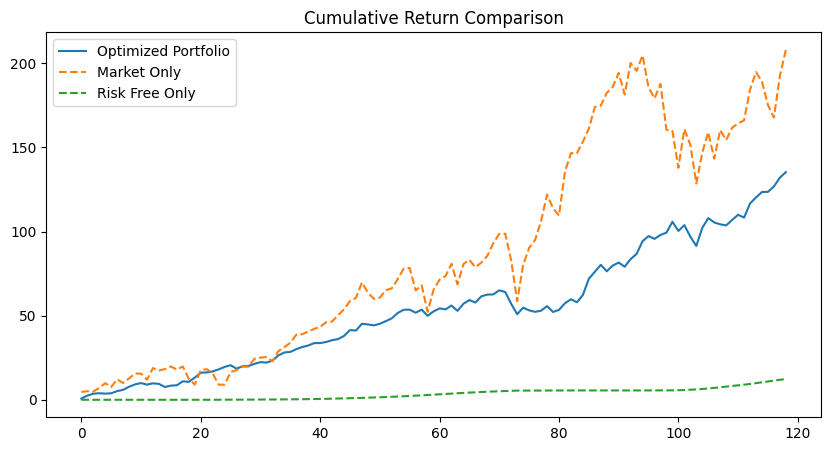

Exposure Factor: 1.00
Optimal Weights: [9.99992786e-01 2.85788158e-06 4.35633055e-06]
Portfolio Mean Return: 1.37%
Portfolio Cumulative return 336.96%
Portfolio Sharpe Ratio: 0.26
Market Mean Return: 1.05%
Market Cumulative return 208.00%
Market Sharpe Ratio: 0.21


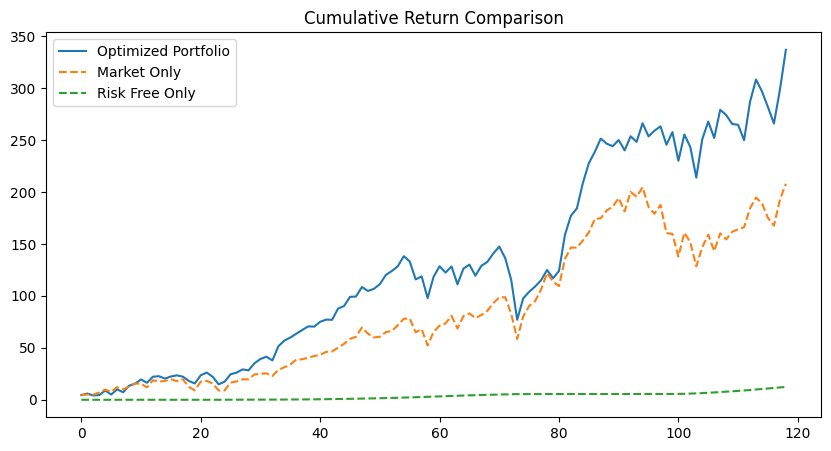

In [256]:
for strat in [['LongShort','mkt_rf'],['longRet','shortRet','mkt_rf']]:
    excess_returns_train = ports['train'][strat]/100
    cov_matrix_train = excess_returns_train.cov()

    # Optimization
    n_assets = excess_returns_train.shape[1]
    initial_weights = np.array([1/n_assets] * n_assets)  # Equal start
    bounds = [(-1, 1) for i in range(n_assets)]
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Fully invested

    optimal_result = minimize(sharpe_ratio, initial_weights, args=(excess_returns_train, cov_matrix_train,n_assets),
                          method='SLSQP', bounds=bounds, constraints=constraints)

    optimal_weights = optimal_result.x

    # Apply weights to test data
    excess_returns_test = ports['test'][strat]/100

    # Performance metrics
    if(n_assets==2):
        exposure_factor = np.abs(optimal_weights).sum() + np.abs(optimal_weights[0])
    else:
        exposure_factor = np.abs(optimal_weights).sum()
    sharpe_ratio_test = -sharpe_ratio(optimal_weights,excess_returns_test,excess_returns_test.cov(),n_assets)
    portfolio_returns_test = excess_returns_test.dot(optimal_weights) + exposure_factor*ports['test']['RF']/100  # Convert back to total return
    mean_return = portfolio_returns_test.mean()*100
    cumulative_return = ((1 + portfolio_returns_test).cumprod()-1)*100/exposure_factor
    cumulative = cumulative_return.iloc[-1]

    # Market-only performance
    total_market_returns =  ports['test']['mkt_rf']/100 + ports['test']['RF']/100
    market_sharpe = -sharpe_ratio(np.array([0]*(n_assets-1)+[1]),excess_returns_test,excess_returns_test.cov(),n_assets)
    mean_m_return = total_market_returns.mean()*100
    market_cumulative_return = ((1 + total_market_returns).cumprod()-1)*100
    market_cumulative = market_cumulative_return.iloc[-1]

    rf_cum = ((1+ports['test']['RF']/100).cumprod()-1)*100

    # Output results
    print(f"Exposure Factor: {exposure_factor:0.2f}")
    print(f"Optimal Weights: {optimal_weights}")
    print(f"Portfolio Mean Return: {mean_return:0.2f}%")
    print(f"Portfolio Cumulative return {cumulative:0.2f}%")
    print(f"Portfolio Sharpe Ratio: {sharpe_ratio_test:0.2f}")
    print(f"Market Mean Return: {mean_m_return:0.2f}%")
    print(f"Market Cumulative return {market_cumulative:0.2f}%")
    print(f"Market Sharpe Ratio: {market_sharpe:0.2f}")
    # Plot cumulative return comparison
    plt.figure(figsize=(10,5))
    plt.plot(cumulative_return, label='Optimized Portfolio')
    plt.plot(market_cumulative_return, label='Market Only', linestyle='--')
    plt.plot(rf_cum, label='Risk Free Only', linestyle='--')
    plt.legend()
    plt.title("Cumulative Return Comparison")
    plt.show()

Exposure Factor: 2.00
Optimal Weights: [ 1. -1.  0.]
Portfolio Mean Return: 0.92%
Portfolio Cumulative return 89.44%
Portfolio Sharpe Ratio: 0.15
Market Mean Return: 1.05%
Market Cumulative return 208.00%
Market Sharpe Ratio: 0.21


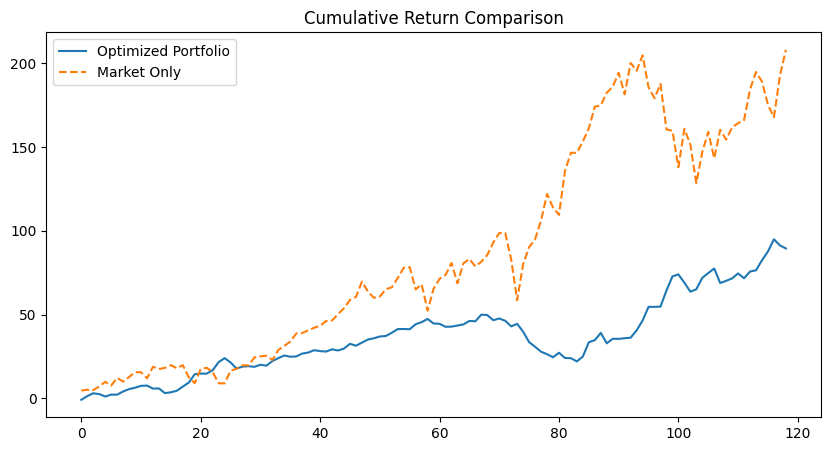

In [257]:
strat = ['longRet','shortRet','mkt_rf']
optimal_weights = np.array([1.0,-1.0,0])

# Apply weights to test data
excess_returns_test = ports['test'][strat]/100
n_assets = excess_returns_test.shape[1]

# Performance metrics
if(n_assets==2):
    exposure_factor = np.abs(optimal_weights).sum() + np.abs(optimal_weights[0])
else:
    exposure_factor = np.abs(optimal_weights).sum()
sharpe_ratio_test = -sharpe_ratio(optimal_weights,excess_returns_test,excess_returns_test.cov(),n_assets)
portfolio_returns_test = excess_returns_test.dot(optimal_weights) + exposure_factor*ports['test']['RF']/100  # Convert back to total return
mean_return = portfolio_returns_test.mean()*100
cumulative_return = ((1 + portfolio_returns_test).cumprod()-1)*100/exposure_factor
cumulative = cumulative_return.iloc[-1]

# Market-only performance
total_market_returns =  ports['test']['mkt_rf']/100 + ports['test']['RF']/100
market_sharpe = -sharpe_ratio(np.array([0]*(n_assets-1)+[1]),excess_returns_test,excess_returns_test.cov(),n_assets)
mean_m_return = total_market_returns.mean()*100
market_cumulative_return = ((1 + total_market_returns).cumprod()-1)*100
market_cumulative = market_cumulative_return.iloc[-1]

# Output results
print(f"Exposure Factor: {exposure_factor:0.2f}")
print(f"Optimal Weights: {optimal_weights}")
print(f"Portfolio Mean Return: {mean_return:0.2f}%")
print(f"Portfolio Cumulative return {cumulative:0.2f}%")
print(f"Portfolio Sharpe Ratio: {sharpe_ratio_test:0.2f}")
print(f"Market Mean Return: {mean_m_return:0.2f}%")
print(f"Market Cumulative return {market_cumulative:0.2f}%")
print(f"Market Sharpe Ratio: {market_sharpe:0.2f}")
# Plot cumulative return comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(cumulative_return, label='Optimized Portfolio')
plt.plot(market_cumulative_return, label='Market Only', linestyle='--')
plt.legend()
plt.title("Cumulative Return Comparison")
plt.show()

Exposure Factor: 2.00
Optimal Weights: [-0.5 -0.5  1. ]
Portfolio Mean Return: 0.24%
Portfolio Cumulative return 14.71%
Portfolio Sharpe Ratio: 0.01
Market Mean Return: 1.05%
Market Cumulative return 208.00%
Market Sharpe Ratio: 0.21


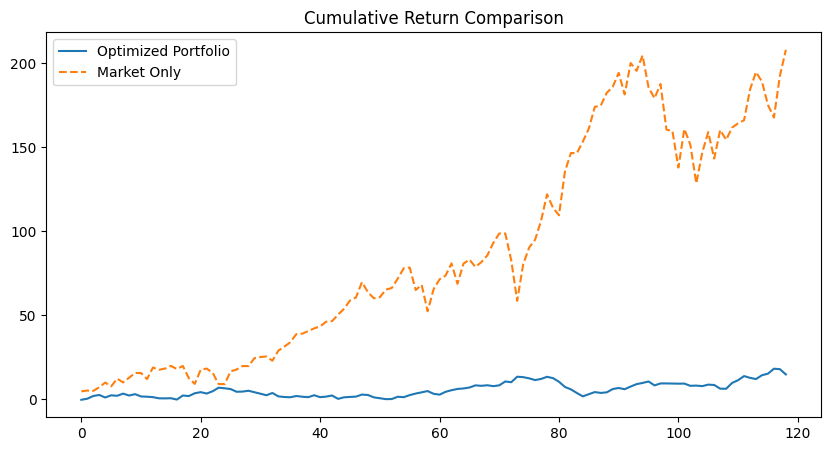

In [258]:
strat = ['longRet','shortRet','mkt_rf']
optimal_weights = np.array([-0.5,-0.5,1])

# Apply weights to test data
excess_returns_test = ports['test'][strat]/100
n_assets = excess_returns_test.shape[1]

# Performance metrics
if(n_assets==2):
    exposure_factor = np.abs(optimal_weights).sum() + np.abs(optimal_weights[0])
else:
    exposure_factor = np.abs(optimal_weights).sum()
sharpe_ratio_test = -sharpe_ratio(optimal_weights,excess_returns_test,excess_returns_test.cov(),n_assets)
portfolio_returns_test = excess_returns_test.dot(optimal_weights) + exposure_factor*ports['test']['RF']/100  # Convert back to total return
mean_return = portfolio_returns_test.mean()*100
cumulative_return = ((1 + portfolio_returns_test).cumprod()-1)*100/exposure_factor
cumulative = cumulative_return.iloc[-1]

# Market-only performance
total_market_returns =  ports['test']['mkt_rf']/100 + ports['test']['RF']/100
market_sharpe = -sharpe_ratio(np.array([0]*(n_assets-1)+[1]),excess_returns_test,excess_returns_test.cov(),n_assets)
mean_m_return = total_market_returns.mean()*100
market_cumulative_return = ((1 + total_market_returns).cumprod()-1)*100
market_cumulative = market_cumulative_return.iloc[-1]

# Output results
print(f"Exposure Factor: {exposure_factor:0.2f}")
print(f"Optimal Weights: {optimal_weights}")
print(f"Portfolio Mean Return: {mean_return:0.2f}%")
print(f"Portfolio Cumulative return {cumulative:0.2f}%")
print(f"Portfolio Sharpe Ratio: {sharpe_ratio_test:0.2f}")
print(f"Market Mean Return: {mean_m_return:0.2f}%")
print(f"Market Cumulative return {market_cumulative:0.2f}%")
print(f"Market Sharpe Ratio: {market_sharpe:0.2f}")
# Plot cumulative return comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(cumulative_return, label='Optimized Portfolio')
plt.plot(market_cumulative_return, label='Market Only', linestyle='--')
plt.legend()
plt.title("Cumulative Return Comparison")
plt.show()

Exposure Factor: 1.53
Optimal Weights: [0.53445821 0.46554179]
Portfolio Mean Return: 1.29%
Portfolio Cumulative return 1492.74%
Portfolio Sharpe Ratio: 0.33
Market Mean Return: 0.84%
Market Cumulative return 536.88%
Market Sharpe Ratio: 0.14


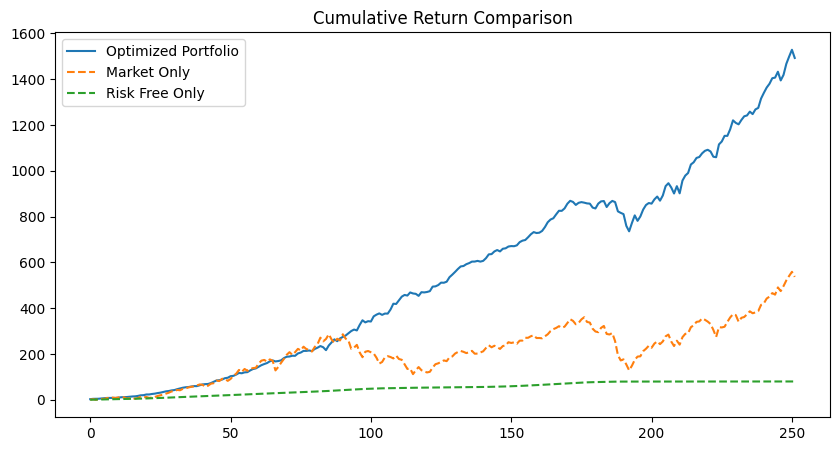

Exposure Factor: 1.00
Optimal Weights: [ 9.99522049e-01  4.81437359e-04 -3.48597469e-06]
Portfolio Mean Return: 1.75%
Portfolio Cumulative return 6187.91%
Portfolio Sharpe Ratio: 0.35
Market Mean Return: 0.84%
Market Cumulative return 536.88%
Market Sharpe Ratio: 0.14


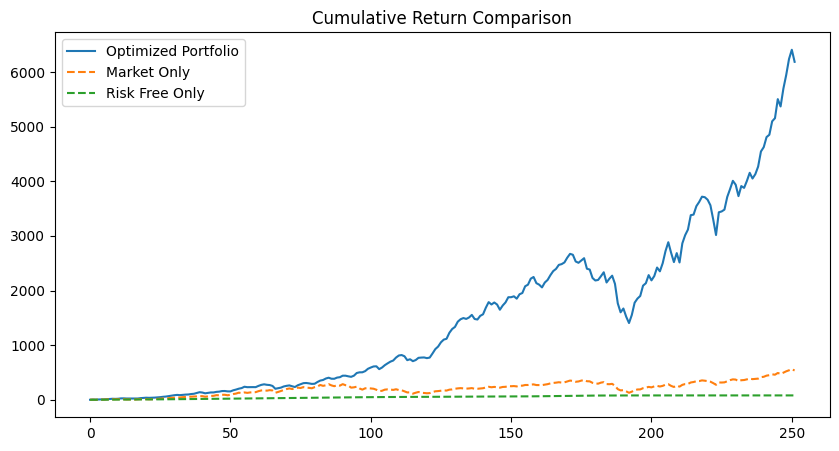

In [263]:
for strat in [['LongShort','mkt_rf'],['longRet','shortRet','mkt_rf']]:
    excess_returns_train = ports['train'][strat]/100
    cov_matrix_train = excess_returns_train.cov()

    # Optimization
    n_assets = excess_returns_train.shape[1]
    initial_weights = np.array([1/n_assets] * n_assets)  # Equal start
    bounds = [(-1, 1) for i in range(n_assets)]
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Fully invested

    optimal_result = minimize(sharpe_ratio, initial_weights, args=(excess_returns_train, cov_matrix_train,n_assets),
                          method='SLSQP', bounds=bounds, constraints=constraints)

    optimal_weights = optimal_result.x

    # Apply weights to test data
    excess_returns_test = ports['train'][strat]/100

    # Performance metrics
    if(n_assets==2):
        exposure_factor = np.abs(optimal_weights).sum() + np.abs(optimal_weights[0])
    else:
        exposure_factor = np.abs(optimal_weights).sum()
    sharpe_ratio_test = -sharpe_ratio(optimal_weights,excess_returns_test,excess_returns_test.cov(),n_assets)
    portfolio_returns_test = excess_returns_test.dot(optimal_weights) + exposure_factor*ports['train']['RF']/100  # Convert back to total return
    mean_return = portfolio_returns_test.mean()*100
    cumulative_return = ((1 + portfolio_returns_test).cumprod()-1)*100/exposure_factor
    cumulative = cumulative_return.iloc[-1]

    # Market-only performance
    total_market_returns =  ports['train']['mkt_rf']/100 + ports['train']['RF']/100
    market_sharpe = -sharpe_ratio(np.array([0]*(n_assets-1)+[1]),excess_returns_test,excess_returns_train.cov(),n_assets)
    mean_m_return = total_market_returns.mean()*100
    market_cumulative_return = ((1 + total_market_returns).cumprod()-1)*100
    market_cumulative = market_cumulative_return.iloc[-1]

    rf_cum = ((1+ports['train']['RF']/100).cumprod()-1)*100

    # Output results
    print(f"Exposure Factor: {exposure_factor:0.2f}")
    print(f"Optimal Weights: {optimal_weights}")
    print(f"Portfolio Mean Return: {mean_return:0.2f}%")
    print(f"Portfolio Cumulative return {cumulative:0.2f}%")
    print(f"Portfolio Sharpe Ratio: {sharpe_ratio_test:0.2f}")
    print(f"Market Mean Return: {mean_m_return:0.2f}%")
    print(f"Market Cumulative return {market_cumulative:0.2f}%")
    print(f"Market Sharpe Ratio: {market_sharpe:0.2f}")
    # Plot cumulative return comparison
    plt.figure(figsize=(10,5))
    plt.plot(cumulative_return, label='Optimized Portfolio')
    plt.plot(market_cumulative_return, label='Market Only', linestyle='--')
    plt.plot(rf_cum, label='Risk Free Only', linestyle='--')
    plt.legend()
    plt.title("Cumulative Return Comparison")
    plt.show()

In [264]:
def sharpe_ratio(weights, excess_returns, cov_matrix,n_assets):
    '''Function to calculate Neg of Sharpe Ratio'''
    if(n_assets==2):
        exposure_factor = np.abs(weights).sum() + np.abs(weights[0])
    else:
        exposure_factor = np.abs(weights).sum()
    portfolio_return = np.dot(weights, excess_returns.mean())
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility # Negative for minimization

Exposure Factor: 1.57
Optimal Weights: [0.57347334 0.42652666]
Portfolio Mean Return: 1.32%
Portfolio Cumulative return 1582.62%
Portfolio Sharpe Ratio: 0.51
Market Mean Return: 0.84%
Market Cumulative return 536.88%
Market Sharpe Ratio: 0.14


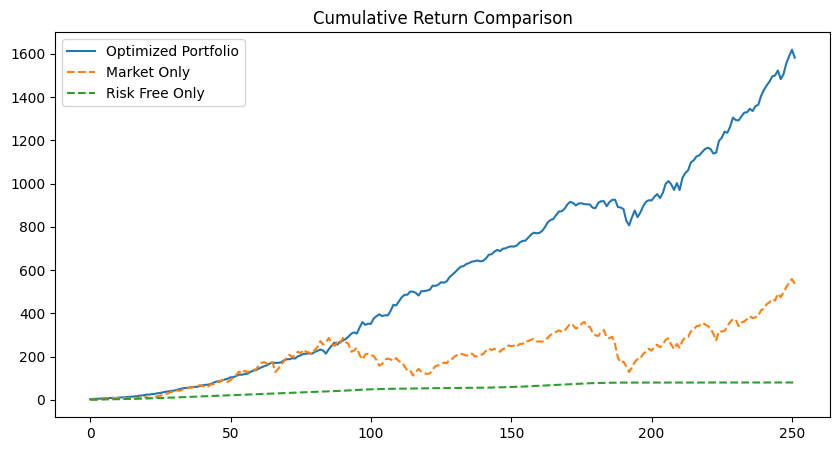

Exposure Factor: 2.68
Optimal Weights: [ 1.         -0.83753728  0.83753728]
Portfolio Mean Return: 2.39%
Portfolio Cumulative return 12161.87%
Portfolio Sharpe Ratio: 0.49
Market Mean Return: 0.84%
Market Cumulative return 536.88%
Market Sharpe Ratio: 0.14


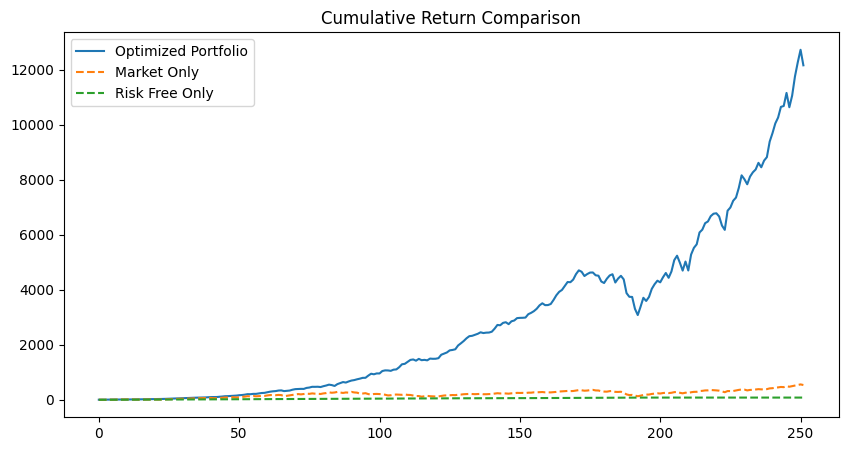

In [265]:
for strat in [['LongShort','mkt_rf'],['longRet','shortRet','mkt_rf']]:
    excess_returns_train = ports['train'][strat]/100
    cov_matrix_train = excess_returns_train.cov()

    # Optimization
    n_assets = excess_returns_train.shape[1]
    initial_weights = np.array([1/n_assets] * n_assets)  # Equal start
    bounds = [(-1, 1) for i in range(n_assets)]
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Fully invested

    optimal_result = minimize(sharpe_ratio, initial_weights, args=(excess_returns_train, cov_matrix_train,n_assets),
                          method='SLSQP', bounds=bounds, constraints=constraints)

    optimal_weights = optimal_result.x

    # Apply weights to test data
    excess_returns_test = ports['train'][strat]/100

    # Performance metrics
    if(n_assets==2):
        exposure_factor = np.abs(optimal_weights).sum() + np.abs(optimal_weights[0])
    else:
        exposure_factor = np.abs(optimal_weights).sum()
    sharpe_ratio_test = -sharpe_ratio(optimal_weights,excess_returns_test,excess_returns_test.cov(),n_assets)
    portfolio_returns_test = excess_returns_test.dot(optimal_weights) + exposure_factor*ports['train']['RF']/100  # Convert back to total return
    mean_return = portfolio_returns_test.mean()*100
    cumulative_return = ((1 + portfolio_returns_test).cumprod()-1)*100/exposure_factor
    cumulative = cumulative_return.iloc[-1]

    # Market-only performance
    total_market_returns =  ports['train']['mkt_rf']/100 + ports['train']['RF']/100
    market_sharpe = -sharpe_ratio(np.array([0]*(n_assets-1)+[1]),excess_returns_test,excess_returns_train.cov(),n_assets)
    mean_m_return = total_market_returns.mean()*100
    market_cumulative_return = ((1 + total_market_returns).cumprod()-1)*100
    market_cumulative = market_cumulative_return.iloc[-1]

    rf_cum = ((1+ports['train']['RF']/100).cumprod()-1)*100

    # Output results
    print(f"Exposure Factor: {exposure_factor:0.2f}")
    print(f"Optimal Weights: {optimal_weights}")
    print(f"Portfolio Mean Return: {mean_return:0.2f}%")
    print(f"Portfolio Cumulative return {cumulative:0.2f}%")
    print(f"Portfolio Sharpe Ratio: {sharpe_ratio_test:0.2f}")
    print(f"Market Mean Return: {mean_m_return:0.2f}%")
    print(f"Market Cumulative return {market_cumulative:0.2f}%")
    print(f"Market Sharpe Ratio: {market_sharpe:0.2f}")
    # Plot cumulative return comparison
    plt.figure(figsize=(10,5))
    plt.plot(cumulative_return, label='Optimized Portfolio')
    plt.plot(market_cumulative_return, label='Market Only', linestyle='--')
    plt.plot(rf_cum, label='Risk Free Only', linestyle='--')
    plt.legend()
    plt.title("Cumulative Return Comparison")
    plt.show()

In [253]:
ports['train'].shape

(252, 10)

In [254]:
ports['test'].shape

(119, 10)